In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polyline

In [6]:
df = pd.read_csv('../data/activities_small.csv', encoding='utf-8') # read is small dataset

In [7]:
df.columns.tolist()

[u'id',
 u'name',
 u'distance',
 u'moving_time',
 u'elapsed_time',
 u'total_elevation_gain',
 u'type',
 u'start_date',
 u'start_date_local',
 u'timezone',
 u'achievement_count',
 u'kudos_count',
 u'comment_count',
 u'athlete_count',
 u'photo_count',
 u'total_photo_count',
 u'trainer',
 u'commute',
 u'manual',
 u'private',
 u'flagged',
 u'average_speed',
 u'max_speed',
 u'average_watts',
 u'max_watts',
 u'weighted_average_watts',
 u'kilojoules',
 u'device_watts',
 u'has_heartrate',
 u'average_heartrate',
 u'max_heartrate',
 u'athlete_id',
 u'map_id',
 u'map_summary_polyline',
 u'start_lat',
 u'start_lng',
 u'end_lat',
 u'end_lng',
 u'state',
 u'closest_city']

In [28]:
df = df[df['commute'] == 0] # drop all where commute = true
df = df[df['state'] == 'Colorado'] # drop all where state != Colorado
df.dropna(subset=['map_summary_polyline'], inplace=True) # drop all where map_summary_polyline is nan
df.reset_index(drop=True, inplace=True)
df.shape

(7164, 40)

In [29]:
df.head()

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,type,start_date,start_date_local,timezone,...,max_heartrate,athlete_id,map_id,map_summary_polyline,start_lat,start_lng,end_lat,end_lng,state,closest_city
0,467664896,Fat Bike in the snow at GM,12557.8,4111.0,4193.0,419.4,Ride,2016-01-10 19:13:47+00:00,2016-01-10 12:13:47,America/Denver,...,NaN,7360660,a467664896,w`gqFnpx`SDzEkDYw@wBApDdBjBGlD~@~@u@pCgJdD_AdM...,39.69,-105.15,39.69,-105.15,Colorado,Lakewood
1,308543489,"05/19/2015 Fruita, CO Horse Thief Bench",15941.8,3448.0,4356.0,322.0,Ride,2015-05-20 00:41:46+00:00,2015-05-19 18:41:46,America/Denver,...,148.0,113571,a308543489,scbnFjbgwSQjMzFhGnAzMJdEgBdBWtDpA`G|NnU`AxImAx...,39.17,-108.83,39.18,-108.83,Colorado,Fruita
2,432799746,Lunch Ride,77276.3,10158.0,15286.0,962.0,Ride,2015-11-14 19:21:32+00:00,2015-11-14 12:21:32,America/Denver,...,NaN,67365,a432799746,kf`sFhaiaS}KiBsAtFyI`ByeAjyBqBjNeJt@iC_EcGsAcn...,39.98,-105.24,39.98,-105.24,Colorado,Boulder
3,308543507,"05/20/2015 Fruita, CO Edge Loop",53577.9,14160.0,19563.0,1355.0,Ride,2015-05-20 15:55:46+00:00,2015-05-20 09:55:46,America/Denver,...,159.0,113571,a308543507,ez|nFrrnvSvRzu@aKhOsw@|FzDxFoKpZlMz_@qBpL}PrCk...,39.31,-108.71,39.31,-108.71,Colorado,Fruita
4,718012436,Lunch ride with Spencer,26395.2,4604.0,4971.0,391.7,Ride,2016-09-19 17:04:45+00:00,2016-09-19 11:04:45,America/Denver,...,NaN,153343,a718012436,sojsFd_naSs@r@|BsCMgBxMaAzByD~b@{@nAsCKaPhBy@v...,40.04,-105.26,40.04,-105.26,Colorado,Boulder


In [30]:
lats = df.start_lat.values

In [31]:
lngs = df.start_lng.values

In [32]:
from itertools import izip
dsts = []
for (lt, lg) in izip(lats, lngs):
    dsts.append(np.sqrt((lats - lt)**2 + (lngs - lg)**2))

In [33]:
dsts = np.array(dsts)
il1 = np.tril_indices(dsts.shape[0])
dsts[il1] = -1

In [34]:
dsts.shape

(7164, 7164)

In [35]:
dsts[:4, :4]

array([[-1.        ,  3.71655755,  0.30364453,  3.58022346],
       [-1.        , -1.        ,  3.68024456,  0.18439089],
       [-1.        , -1.        , -1.        ,  3.53409111],
       [-1.        , -1.        , -1.        , -1.        ]])

In [36]:
pairs = np.argwhere((dsts <= 0.01) & (dsts > -1)) # all pairs of indices with distances shorter than threshold

In [37]:
pairs[:15]

array([[   0,  466],
       [   0, 1818],
       [   0, 1873],
       [   0, 2731],
       [   0, 2790],
       [   0, 3904],
       [   0, 7025],
       [   1,  216],
       [   1,  547],
       [   1, 1152],
       [   1, 1260],
       [   1, 1591],
       [   1, 3346],
       [   1, 4471],
       [   1, 5295]])

In [38]:
len(pairs)

219351

In [39]:
def make_indexer(arr): # might not need indexer
    indexer = {}
    for pair in arr:
        if pair[0] in indexer:
            indexer[pair[0]].append(pair[1])
        else:
            indexer[pair[0]] = [pair[1]]
    return indexer
start_clusters = make_indexer(pairs)

In [40]:
# start_clusters

In [41]:
poly1 = np.array(polyline.decode(df.ix[0, 'map_summary_polyline'])).flatten()

In [42]:
poly2 = np.array(polyline.decode(df.ix[2574, 'map_summary_polyline'])).flatten()

In [43]:
len(poly1)

170

In [44]:
len(poly2)

122

In [45]:
def polytrim(poly1, poly2):
    diff = len(poly1) - len(poly2)
    rands = np.random.choice(np.arange(0, len(poly1)-2, 2), diff/2, replace=False)
    return np.delete(poly1, np.hstack((rands,rands+1)))

def conditional_dist(poly1, poly2):
    if np.linalg.norm(np.subtract(poly1[-2:], poly2[-2:])) <= 0.01: # if end points are close by a certain threshold
        if len(poly1) > len(poly2):
            poly1 = polytrim(poly1, poly2)
        elif len(poly1) < len(poly2):
            poly2 = polytrim(poly2, poly1)
        return np.linalg.norm(np.subtract(poly1, poly2))

In [46]:
poly_pair_dsts = []
for idx1, other_idxs in start_clusters.iteritems():
    for idx2 in other_idxs:
        poly1 = np.array(polyline.decode(df.ix[idx1, 'map_summary_polyline'])).flatten()
        poly2 = np.array(polyline.decode(df.ix[idx2, 'map_summary_polyline'])).flatten()
        dist = conditional_dist(poly1, poly2)
        if dist < 3.0
            poly_pair_dsts.append(dist)


In [47]:
len(poly_pair_dsts)

125366

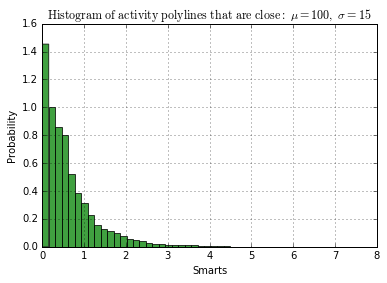

In [63]:
import matplotlib.mlab as mlab
x = poly_pair_dsts

# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ activity\ polylines\ that\ are\ close:}\ \mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

In [64]:
from scipy import stats

In [68]:
rslt = stats.describe(poly_pair_dsts)
print "mean: {}".format(rslt.mean), "var: {}".format(rslt.variance)

mean: 0.642107140817 var: 0.464549072321
